## Regional Satellite / WRF-Chem comparison script

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
from matplotlib import ticker
from matplotlib import interactive
interactive(True)

import xarray as xr
import numpy as np
import pandas as pd

from scipy import stats


In [2]:
# loads column and lat/lon data, and converts to panda array.
#    This includes copying the time index to our model data, because
#    I had not added this to the model netcdf files when creating them.
def load_create_dataframe(sat_datadask,model_datadask):

    sat_col_data = sat_datadask.column.copy(deep=True)
    sat_error_data = sat_datadask.error.copy(deep=True)
    sat_vprof_data = sat_datadask.VertProf.copy(deep=True)
    sat_clcov_data = sat_datadask.CLcov.copy(deep=True)
    sat_angle_data = sat_datadask.angle.copy(deep=True)
    lat_data = sat_datadask.latitude.copy(deep=True)
    lon_data = sat_datadask.longitude.copy(deep=True)
    
    # convert from xarray to pandas dataframe
    cold = sat_col_data.to_dataframe()
    errd = sat_error_data.to_dataframe()
    verd = sat_vprof_data.to_dataframe()
    clcd = sat_clcov_data.to_dataframe()
    angd = sat_angle_data.to_dataframe()
    latd = lat_data.to_dataframe()
    lond = lon_data.to_dataframe()
 
    # pull out time from the satellite data
    sat_time_data = satellite_datadask.time.copy(deep=True)
    sat_time = sat_time_data.to_dataframe().reset_index(drop=True)
    
    # load and add time to the model data
    model_data = model_datadask.nh3.copy(deep=True)
    model = model_data.to_dataframe().reset_index(drop=True)
    model_time = pd.concat([sat_time,model],axis=1,sort=False)
    modd = model_time.set_index('time')
    
    result = pd.concat([modd,cold,errd,verd,clcd,angd,latd,lond], axis=1, sort=False)

    return result

#### Load satellite and model data

The 'time' index in the satellite data is 'UTC time of acquisition', in units 'HHMMSS.ms', so I think that we need to be careful to only load data for a single day at a time for this processing. Otherwise the coordinate system could become confused by duplicate values for each day. This doesn't matter for the global satellite data plots, but for this work we are merging model and satellite data, and so we need to be more careful with indexing.

In [3]:
satellite_file_path = '/Volumes/Work_Space/Clearflo/satellite_data/'
model_file_path = '/Volumes/Work_Space/Clearflo/model_column_data/'
date_string = '20120812_*'
satellite_datadask = xr.open_mfdataset(satellite_file_path+'nh3nn_v2_2_'+date_string+'.nc')
model_datadask = xr.open_mfdataset(model_file_path+'Ammonia_Column_'+date_string+'_gasphase_chemistry.nc')

In [4]:
work_data = load_create_dataframe(satellite_datadask,model_datadask)

/Users/mbessdl2/anaconda3/envs/iris/lib/python3.6/site-packages/xarray/coding/variables.py:135: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


### Data cleaning and sorting

Cleaning:
* I drop any NaN's in the data (both to zoom into the model domain, as work_data.nh3 will be NaN outside of this, and to get rid of the missing values in the satellite data, where work_data.column is a NaN). 
* I also get rid of the negative satellite values (simply by locating all lines where column > 0.0)

Sorting.

Main categories:
* cd_all:  all co-located model/satellite data
* cd_land: all retrievals flagged as land-based
* cd_sea:  all retrievals flagged as sea-based
* cd_high: satellite zenith angles < 10 degrees
* cd_low:  satellite zenith angles > 45 degrees

Combined categories:
* cd_sea_low
* cd_sea_high
* cd_land_low
* cd_land_high

In [5]:
clean_data = work_data.dropna()
clean_data_extra = clean_data.loc[clean_data['column']>0.0]
#cd2 = clean_data_extra.reset_index()
#cd_all = cd2.set_index(['VertProf','time'])
#cd_land = cd_all.loc(axis=0)[1]
#cd_sea  = cd_all.loc(axis=0)[0]
cd_all  = clean_data_extra
cd_land = cd_all.loc[cd_all['VertProf']==1]
cd_sea  = cd_all.loc[cd_all['VertProf']==0]
cd_high = cd_all.loc[cd_all['angle']<10]
cd_low  = cd_all.loc[cd_all['angle']>45]

cd_sea_high = cd_sea.loc[cd_sea['angle']<10]
cd_land_high = cd_land.loc[cd_land['angle']<10]
cd_sea_low = cd_sea.loc[cd_sea['angle']>45]
cd_land_low = cd_land.loc[cd_land['angle']>45]

In [6]:
def stat_report(dataset,dataname):
    slope, intercept, r_value, p_value, std_err = stats.linregress(dataset.column,dataset.nh3)
    print("For ",dataname)
    print("  count is:", dataset.column.count())
    print("  slope is:", slope)
    print("  r-squared:", r_value**2)


stat_report(clean_data,"clean_data, with negative values")
stat_report(cd_all,"cd_all, without negative values")
stat_report(cd_land,"cd_land")
stat_report(cd_sea,"cd_sea")
stat_report(cd_high,"cd_high")
stat_report(cd_low,"cd_low")
stat_report(cd_sea_high,"cd_sea_high")
stat_report(cd_sea_low,"cd_sea_low")
stat_report(cd_land_high,"cd_land_high")
stat_report(cd_land_low,"cd_land_low")

For  clean_data, with negative values
  count is: 2830
  slope is: 0.04442704489807064
  r-squared: 0.0116133978060563
For  cd_all, without negative values
  count is: 1808
  slope is: 0.09598993051407624
  r-squared: 0.03570603060073805
For  cd_land
  count is: 923
  slope is: 0.11358417793628765
  r-squared: 0.06750261383953217
For  cd_sea
  count is: 885
  slope is: 0.11102022356098375
  r-squared: 0.027003923893658906
For  cd_high
  count is: 259
  slope is: 0.22916528505897815
  r-squared: 0.18640363324884568
For  cd_low
  count is: 448
  slope is: 0.19208002070945562
  r-squared: 0.11582917633763615
For  cd_sea_high
  count is: 79
  slope is: 0.16061932139262522
  r-squared: 0.11933763771439394
For  cd_sea_low
  count is: 300
  slope is: 0.09431804644129314
  r-squared: 0.016626396243348003
For  cd_land_high
  count is: 180
  slope is: 0.1835482370099715
  r-squared: 0.13765463343433182
For  cd_land_low
  count is: 148
  slope is: 0.21031790558246813
  r-squared: 0.14558309283762

### Data plotting

There's a lot more variation in the satellite data, and it does seem to go higher than the model data (with not a great deal of correlation between the two).

To do: 
* addition of error bars for satellite data


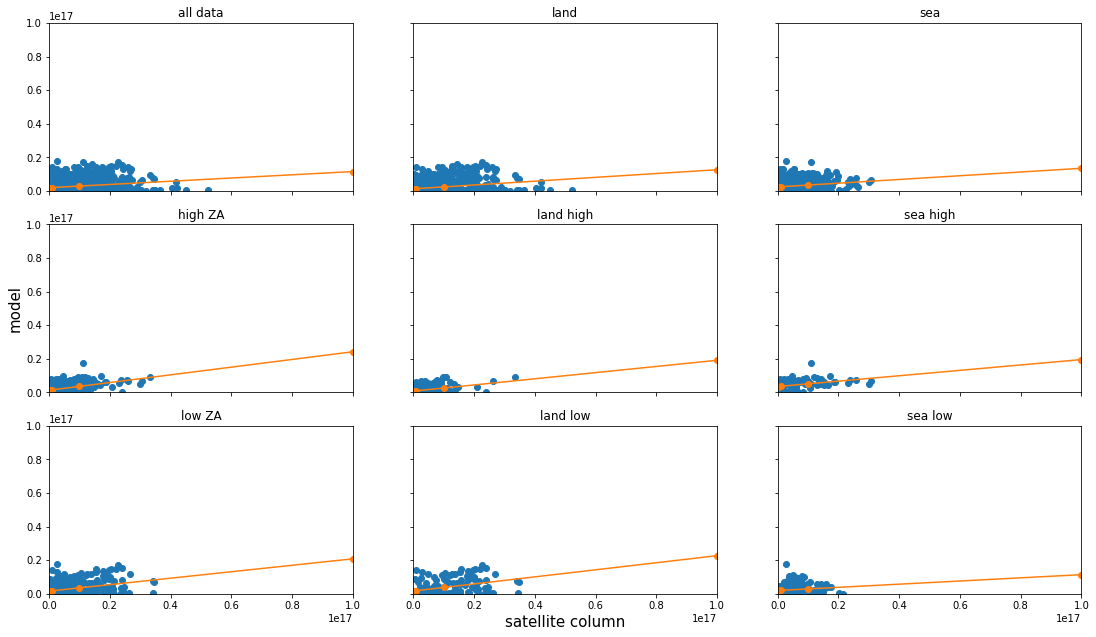

In [8]:
def nh3_plot(cd_plot,ax,titlestring):

    xline = np.array([1e12,1e13,1e14,1e15,1e16,1e17])

    slope, intercept, r_value, p_value, std_err = stats.linregress(cd_plot.column,cd_plot.nh3)
    line = slope*xline+intercept

    #ax.set_xscale("log", nonposx='clip')
    #ax.set_yscale("log", nonposy='clip')
    #ax.scatter(cd_plot.column, cd_plot.nh3)
    ax.plot(cd_plot.column, cd_plot.nh3, 'o', xline, line, 'o-')
    ax.set_title(titlestring)
    ax.set_xlim(1e12,1e17)
    ax.set_ylim(1e12,1e17)

fig, axes = plt.subplots(3, 3, sharex='all', sharey='all')
fig.set_size_inches(18.5, 10.5)
axes[2,1].set_xlabel(r'satellite column', fontsize=15)
axes[1,0].set_ylabel(r'model', fontsize=15)

nh3_plot(cd_all,axes[0,0],"all data")
nh3_plot(cd_land,axes[0,1],"land")
nh3_plot(cd_sea,axes[0,2],"sea")

nh3_plot(cd_high,axes[1,0],"high ZA")
nh3_plot(cd_low,axes[2,0],"low ZA")

nh3_plot(cd_land_high,axes[1,1],"land high")
nh3_plot(cd_sea_high,axes[1,2],"sea high")

nh3_plot(cd_land_low,axes[2,1],"land low")
nh3_plot(cd_sea_low,axes[2,2],"sea low")
